In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

In [7]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [8]:
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)

In [9]:
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [10]:
from sklearn.datasets import fetch_california_housing

# Load data
housing = fetch_california_housing()


In [11]:
housing_df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
housing_df
target = housing.target

In [12]:
housing_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [13]:
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Text(0.5, 1.0, 'Comprehensive Correlation Heatmap')

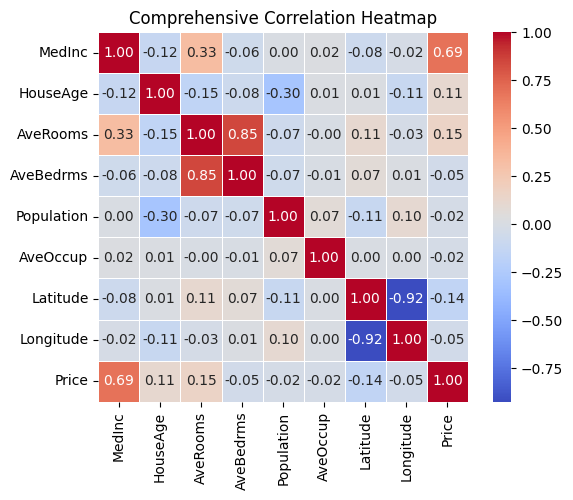

In [14]:
df = housing_df.copy()
df['Price'] = target

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
        square=True, cbar=True, fmt='.2f')
plt.title('Comprehensive Correlation Heatmap', fontsize=12)



Text(0, 0.5, 'Frequency')

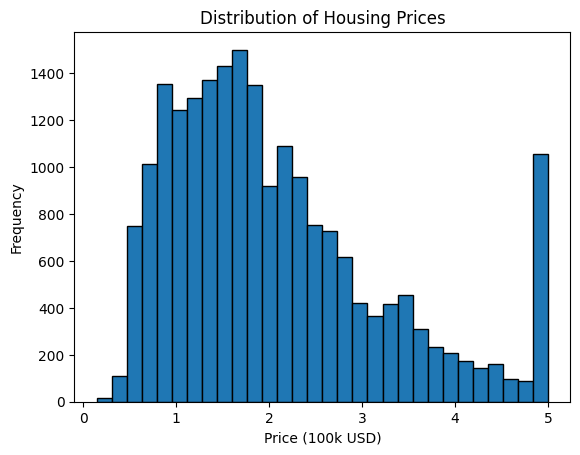

In [15]:
plt.hist(target, bins=30, edgecolor='black')
plt.title('Distribution of Housing Prices', fontsize=12)
plt.xlabel('Price (100k USD)')
plt.ylabel('Frequency')

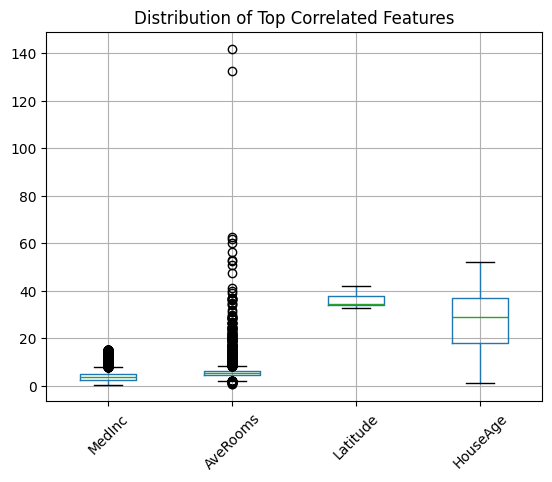

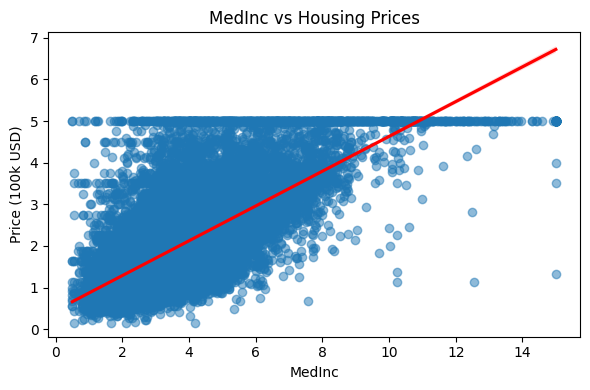

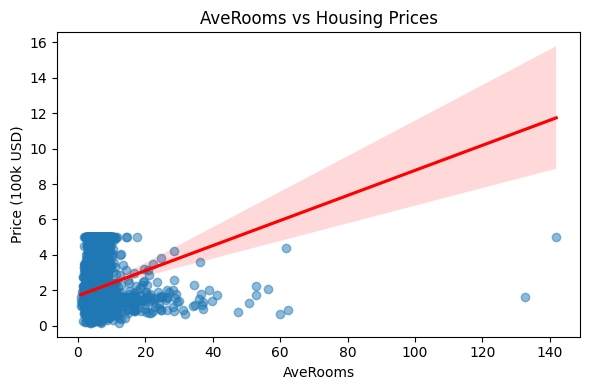

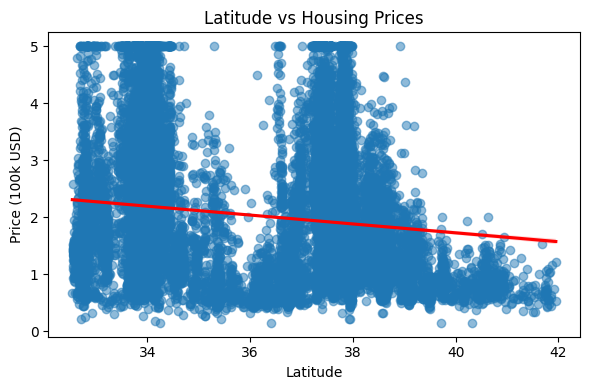

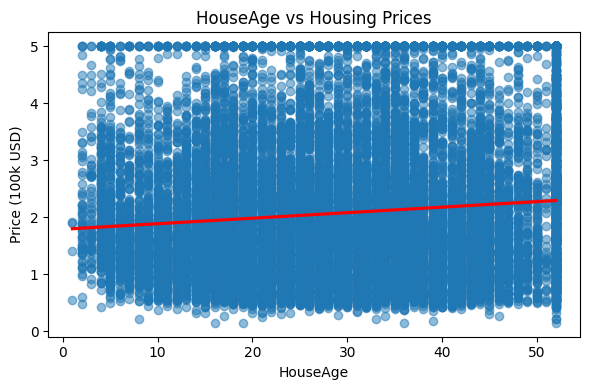

<Figure size 640x480 with 0 Axes>

In [16]:

top_features = corr_matrix['Price'].abs().sort_values(ascending=False)[:5].index.tolist()
top_features.remove('Price')
df[top_features + ['Price']].boxplot(column=top_features)
plt.title('Distribution of Top Correlated Features', fontsize=12)
plt.xticks(rotation=45)

# 4. Scatter Plot of Top Features vs Price


for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=df[feature], y=df['Price'], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    plt.title(f'{feature} vs Housing Prices', fontsize=12)
    plt.xlabel(feature)
    plt.ylabel('Price (100k USD)')
    plt.tight_layout()
    plt.show()




plt.tight_layout()
plt.show()

In [17]:
def detect_and_remove_outliers(df, target, method='iqr', contamination=0.1):
    # Combine features and target for outlier detection
    df_with_target = df.copy()
    df_with_target['target'] = target
    
    if method == 'iqr':
        # IQR Method
        Q1 = df_with_target.quantile(0.20)
        Q3 = df_with_target.quantile(0.80)
        IQR = Q3 - Q1
        
        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Create mask for non-outliers
        outlier_mask = ~((df_with_target < lower_bound) | (df_with_target > upper_bound)).any(axis=1)
    
    elif method == 'zscore':
        # Z-score Method
        from scipy import stats
        
        # Calculate z-scores
        z_scores = np.abs(stats.zscore(df_with_target))
        
        # Identify outliers (z-score > 3)
        outlier_mask = (z_scores < 3).all(axis=1)
    
    # Remove outliers
    df_cleaned = df_with_target[outlier_mask].drop('target', axis=1)
    target_cleaned = df_with_target.loc[outlier_mask, 'target']
    
    print(f"Removed {len(df) - len(df_cleaned)} outliers out of {len(df)} samples")
    
    return df_cleaned, target_cleaned

def preprocess_data(housing_df, target, test_size=0.2, random_state=42, remove_outliers=True):

    # Optionally remove outliers
    if remove_outliers:
        housing_df, target = detect_and_remove_outliers(housing_df, target, method='iqr')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        housing_df, target, test_size=test_size, random_state=random_state
    )
    
    # Preprocessing steps
    # 1. Imputation
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # 2. Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # 3. Polynomial Features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)
    
    # 4. Feature Selection
    selector = SelectKBest(f_regression, k=10)
    X_train_selected = selector.fit_transform(X_train_poly, y_train)
    X_test_selected = selector.transform(X_test_poly)
    
    return (X_train_selected, X_test_selected, 
            y_train, y_test)


In [18]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train multiple models and compare their performance
    """
    # Define models with their hyperparameters
    models = {
        'Ridge Regression': Ridge(alpha=10.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(
            n_estimators=200, 
            max_depth=20, 
            min_samples_split=5
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=200, 
            learning_rate=0.1, 
            max_depth=5
        ),
        'XGBoost': XGBRegressor(
            n_estimators=200, 
            learning_rate=0.1, 
            max_depth=5
        )
    }
    
    # Results storage
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Compute metrics
        results[name] = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'MAPE': mean_absolute_percentage_error(y_test, y_pred)
        }
    
    # Print results
    print("Model Performance Comparison:")
    for name, metrics in results.items():
        print(f"\n{name} Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return results

In [19]:
X_train, X_test, y_train, y_test = preprocess_data(housing_df, target)


Removed 2387 outliers out of 20640 samples


In [20]:
model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)


Model Performance Comparison:

Ridge Regression Performance:
MSE: 0.5142
RMSE: 0.7170
MAE: 0.5316
R2: 0.5744
MAPE: 0.3269

Lasso Regression Performance:
MSE: 1.2083
RMSE: 1.0992
MAE: 0.8662
R2: -0.0000
MAPE: 0.5944

Random Forest Performance:
MSE: 0.3681
RMSE: 0.6067
MAE: 0.4245
R2: 0.6953
MAPE: 0.2444

Gradient Boosting Performance:
MSE: 0.3644
RMSE: 0.6037
MAE: 0.4274
R2: 0.6984
MAPE: 0.2468

XGBoost Performance:
MSE: 0.3569
RMSE: 0.5974
MAE: 0.4233
R2: 0.7046
MAPE: 0.2454


In [21]:
model_results

{'Ridge Regression': {'MSE': 0.5141575708277689,
  'RMSE': 0.7170478162771078,
  'MAE': 0.5315614983393632,
  'R2': 0.5744459255237528,
  'MAPE': 0.32685277965199366},
 'Lasso Regression': {'MSE': 1.2082630329697095,
  'RMSE': 1.0992101859834222,
  'MAE': 0.8661997918939377,
  'R2': -4.6067378685066274e-05,
  'MAPE': 0.5944421935663513},
 'Random Forest': {'MSE': 0.36812154966401384,
  'RMSE': 0.606730211596566,
  'MAE': 0.4244841468552617,
  'R2': 0.6953159221018116,
  'MAPE': 0.2443980453001086},
 'Gradient Boosting': {'MSE': 0.3644475108483851,
  'RMSE': 0.6036948822446527,
  'MAE': 0.427409329108938,
  'R2': 0.6983568229393846,
  'MAPE': 0.24676128638143502},
 'XGBoost': {'MSE': 0.35694523549607154,
  'RMSE': 0.597448939655994,
  'MAE': 0.42334031728697485,
  'R2': 0.704566249825543,
  'MAPE': 0.24535045099328479}}

In [22]:
best_model_name = min(model_results, key=lambda x: model_results[x]['RMSE'])
print(f"\nBest Model: {best_model_name}")


Best Model: XGBoost


In [23]:
models = {
    'Ridge Regression': Ridge(alpha=10.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    ),
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5
    )
}

In [24]:
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
import pickle


In [33]:

model_pipeline = {
    'model': best_model,
}
with open("regmodel.pkl", "wb") as f:
    pickle.dump(model_pipeline, f)

In [40]:
# Evaluate performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Load the model
pickled_model = pickle.load(open('regmodel.pkl', 'rb'))
model = pickled_model['model']

# Predict
y_pred = model.predict(X_test[:1])

# Metrics
print(f"Predicted Price: {y_pred[0]:.2f} (100k USD)")
print(f"Actual Price: {y_test.iloc[0]:.2f} (100k USD)")


Predicted Price: 0.94 (100k USD)
Actual Price: 0.83 (100k USD)
